# Import danych i bibliotek
Klasyczny początek z importem potrzebnych bibliotek

In [ ]:
import pandas as pd
from numpy import array
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
raw_df = pd.read_csv("https://lovespreadsheet-tutorials.s3.amazonaws.com/APIDatasets/congressional_voting_dataset.csv")

# Preprocessing
Przygotowanie zbioru do modelowania okazało się dosyć łatwe.

In [ ]:
raw_df

,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa,political_party
0,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y,republican
1,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?,republican
2,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n,democrat
3,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y,democrat
4,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y,democrat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,n,n,y,y,y,y,n,n,y,y,n,y,y,y,n,y,republican
431,n,n,y,n,n,n,y,y,y,y,n,n,n,n,n,y,democrat
432,n,?,n,y,y,y,n,n,n,n,y,y,y,y,n,y,republican
433,n,n,n,y,y,y,?,?,?,?,n,y,y,y,n,y,republican


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

df = raw_df.copy()

# kodowanie tak, żeby zachować stopniowanie głosów (n < ? < y)
vote_encoder = OrdinalEncoder([["n", "?", "y"]]*16) # n -> 0, ? -> 1, y -> 2
df.iloc[:, :-1] = vote_encoder.fit_transform(df.iloc[:, :-1]) 

party_encoder = LabelEncoder()
party_encoder.fit(["republican", "democrat"]) # republican -> 1, democrat -> 0
df.iloc[:, -1] = party_encoder.transform(df.iloc[:, -1])

df = df.convert_dtypes()
df

,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa,political_party
0,0,2,0,2,2,2,0,0,0,2,1,2,2,2,0,2,1
1,0,2,0,2,2,2,0,0,0,0,0,2,2,2,0,1,1
2,1,2,2,1,2,2,0,0,0,0,2,0,2,2,0,0,0
3,0,2,2,0,1,2,0,0,0,0,2,0,2,0,0,2,0
4,2,2,2,0,2,2,0,0,0,0,2,1,2,2,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,0,0,2,2,2,2,0,0,2,2,0,2,2,2,0,2,1
431,0,0,2,0,0,0,2,2,2,2,0,0,0,0,0,2,0
432,0,1,0,2,2,2,0,0,0,0,2,2,2,2,0,2,1
433,0,0,0,2,2,2,1,1,1,1,0,2,2,2,0,2,1


In [ ]:
# podział na feature, label
X = df.iloc[:, :-1]
y = df.iloc[:, -1].astype("int")

Zdecyodwaliśmy się na użycie kodowania stopniowego, ponieważ uznaliśmy, że stopniowanie 

`"głosował przeciwko" < "wstrzymał się od głosu" < "głosował za"`

jest na tyle silne, że nie trzeba kodować za pomocą OneHotEncoding.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype
---  ------                                  --------------  -----
 0   handicapped_infants                     435 non-null    Int64
 1   water_project_cost_sharing              435 non-null    Int64
 2   adoption_of_the_budget_resolution       435 non-null    Int64
 3   physician_fee_freeze                    435 non-null    Int64
 4   el_salvador_aid                         435 non-null    Int64
 5   religious_groups_in_schools             435 non-null    Int64
 6   anti_satellite_test_ban                 435 non-null    Int64
 7   aid_to_nicaraguan_contras               435 non-null    Int64
 8   mx_missile                              435 non-null    Int64
 9   immigration                             435 non-null    Int64
 10  synfuels_corporation_cutback            435 non-null    Int64
 11  education_spending 

Jak widać, wszystko jest w typie Int64, więc zabieramy się do wstępnego modelowania.

# Wstępne modelowanie

## Proste (domyślne) drzewo decyzyjne
Jako pierwszy model zdecydowaliśmy się stworzyć drzewo decyzyjne. Dane są w końcu decyzjami, więc być może model będzie sobie dobrze radził na nich.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24, test_size=0.4) 

from sklearn.tree import DecisionTreeClassifier
basic = DecisionTreeClassifier(random_state=420)
basic.fit(X=X_train, y=y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=420, splitter='best')

Będziemy korzystać z dużego zbioru testowego (0.4), ponieważ cały nasz zbiór danych jest dosyć mały.

In [ ]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
def print_metrics(model):
  print(f"Accuracy score (train): {model.score(X_train, y_train)}")
  print(f"Accuracy score (test): {model.score(X_test, y_test)}")
  print(f"Tree depth: {model.get_depth()}")
  print(f"Leaf count: {model.get_n_leaves()}")

print_metrics(basic)

Accuracy score (train): 1.0
Accuracy score (test): 0.9425287356321839
Tree depth: 7
Leaf count: 17


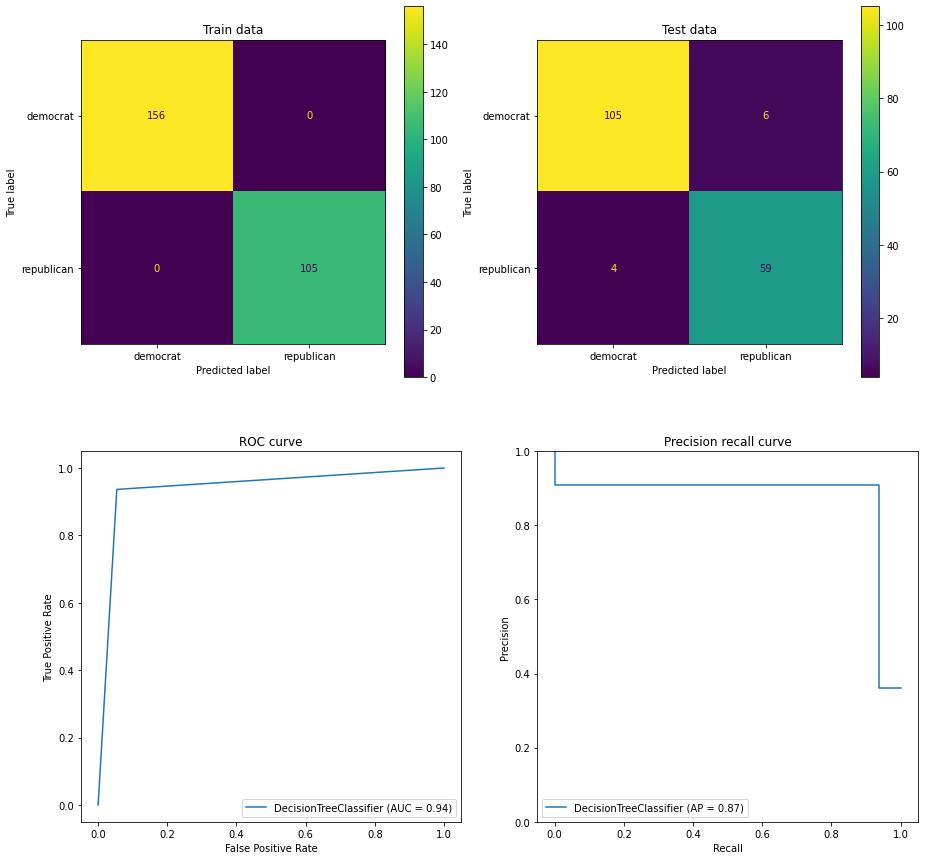

In [ ]:
def plot_scores(model):
  fig, axs = plt.subplots(2, 2)
  plot_confusion_matrix(
      model, X_train, y_train,
      display_labels=party_encoder.classes_,
      values_format="d",
      ax=axs[0, 0]
  )
  axs[0, 0].set_title("Train data")

  plot_confusion_matrix(
      model, X_test, y_test,
      display_labels=party_encoder.classes_,
      values_format="d",
      ax=axs[0, 1]
  )
  axs[0, 1].set_title("Test data")

  plot_roc_curve(model, X_test, y_test, ax=axs[1, 0])
  axs[1,0].set_title("ROC curve")

  plot_precision_recall_curve(model, X_test, y_test, ax=axs[1, 1])
  axs[1, 1].set_title("Precision recall curve")
  axs[1, 1].set_ylim(0, 1)
  
  fig.set_size_inches(15, 15)
  fig.show()
  

plot_scores(basic)

Wynik, jak na model gdzie wszystko jest domyślne wygląda bardzo dobrze, aczkolwiek powstałe drzewo decyzyjne jest dosyć duże.
Być może da się stworzyć model o podobnej jakości, ale o mniejszej liczbie liści?

## Małe, mniejsze i najmniejsze drzewo decyzyjne
Niezły wynik domyślnego drzewa decyzyjnego zachęca do zmniejszenia drzewa.Wysoki wynik dla zbioru treningowego może oznaczać, że model się przeucza.

In [ ]:
smol = DecisionTreeClassifier(random_state=420, max_depth=3, max_leaf_nodes=10)
smol.fit(X=X_train, y=y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=420, splitter='best')

In [ ]:
print_metrics(smol)

Accuracy score (train): 0.9693486590038314
Accuracy score (test): 0.9540229885057471
Tree depth: 3
Leaf count: 7


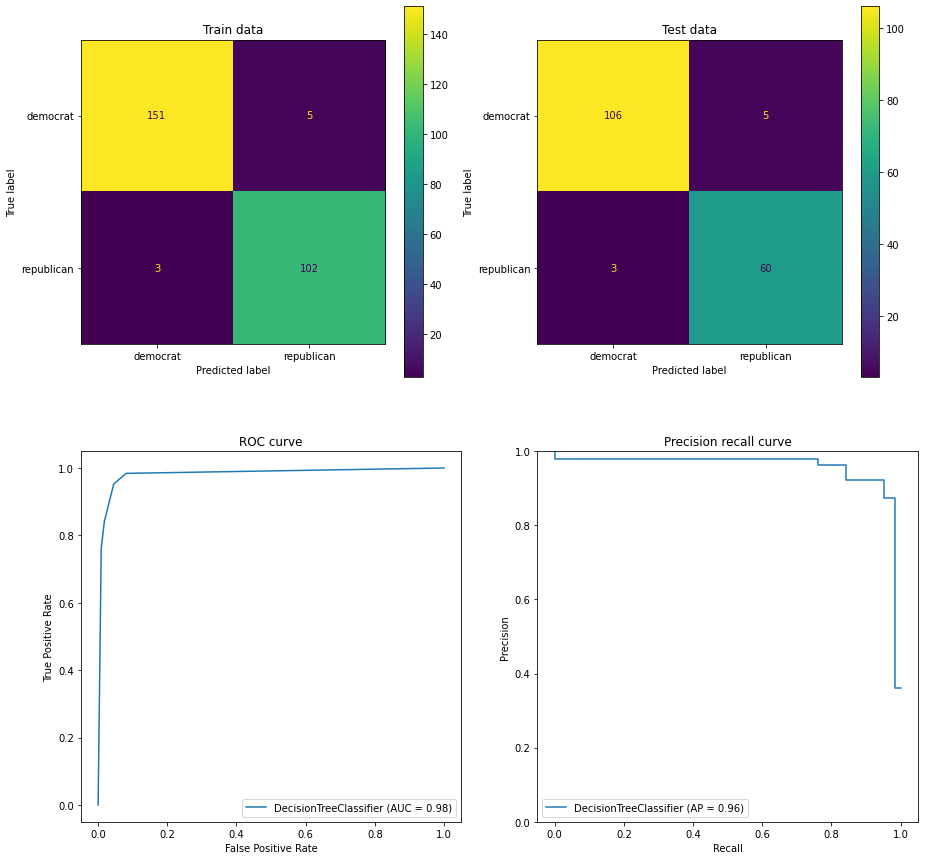

In [ ]:
plot_scores(smol)

Model okazuje się lepszy dla danych spoza zbioru treningowego! Przeuczaliśmy ten pierwszy i gorzej radził sobie na nowych danych. Jako bonus, możemy teraz dobrze wizualizować to drzewo. Ponieważ drzewo jest znacznie mniejsze, to model jest łatwy do interpretacji.

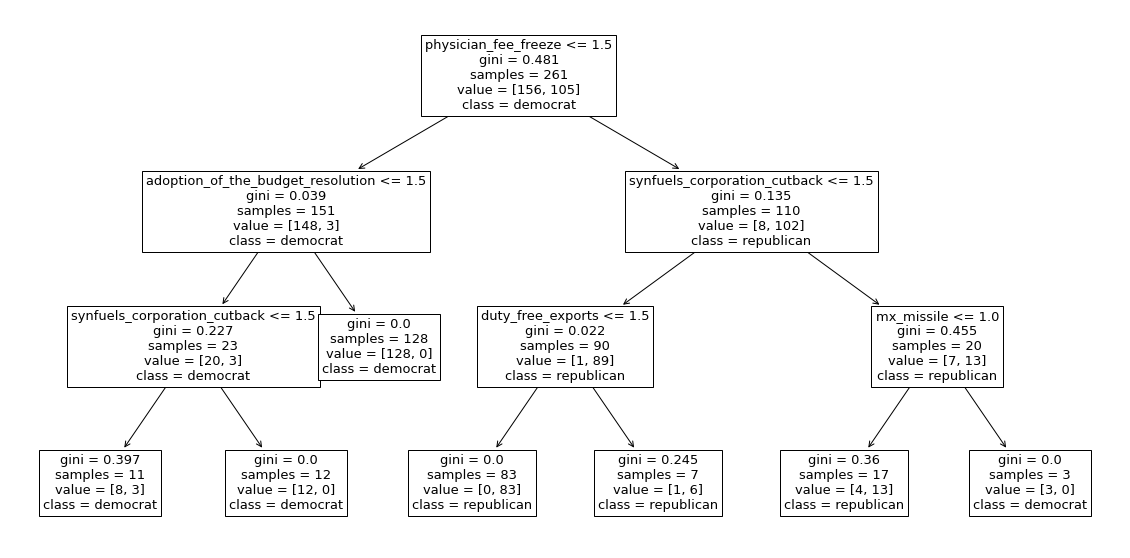

In [ ]:
from sklearn.tree import plot_tree
def plot_model(model):
  plt.figure(figsize=(20, 10))
  plot_tree(model, feature_names=df.iloc[:, :-1].columns, class_names=party_encoder.classes_,fontsize=13)
  plt.show()

plot_model(smol)

Skoro mniejsze drzewo jest lepsze od większego to może lepiej jeszcze bardziej je zmniejszyć?

In [ ]:
smoler = DecisionTreeClassifier(random_state=420, max_depth=2)
smoler.fit(X=X_train, y=y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=420, splitter='best')

In [ ]:
print_metrics(smoler)

Accuracy score (train): 0.9578544061302682
Accuracy score (test): 0.9540229885057471
Tree depth: 2
Leaf count: 4


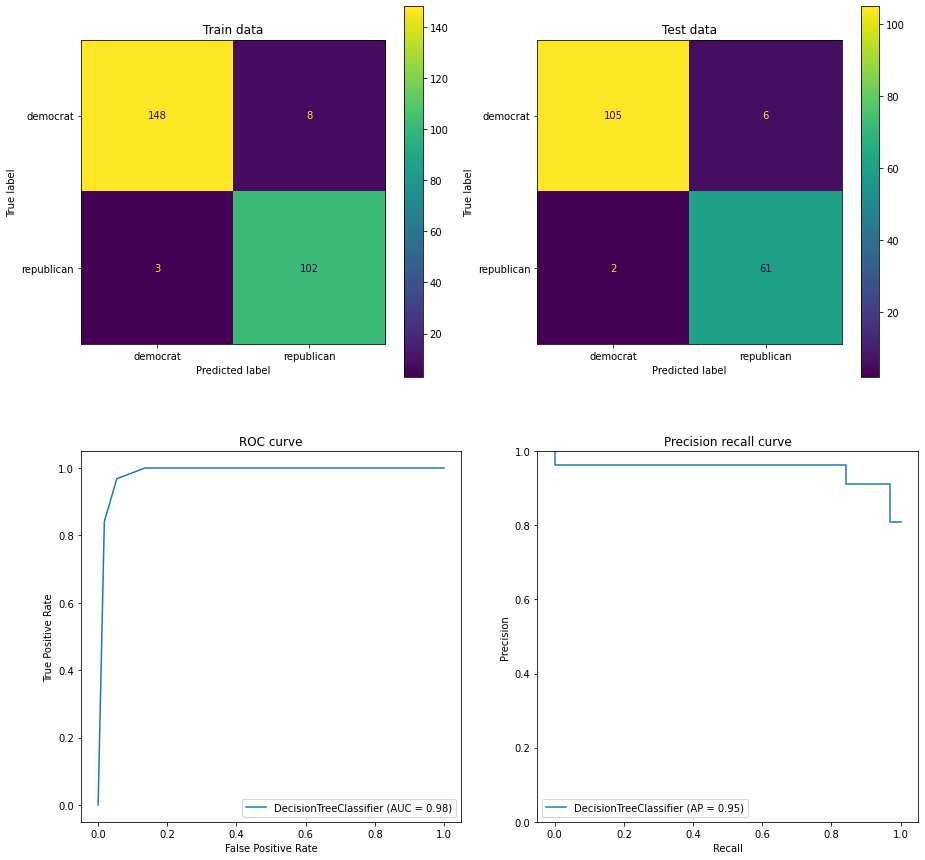

In [ ]:
plot_scores(smoler)

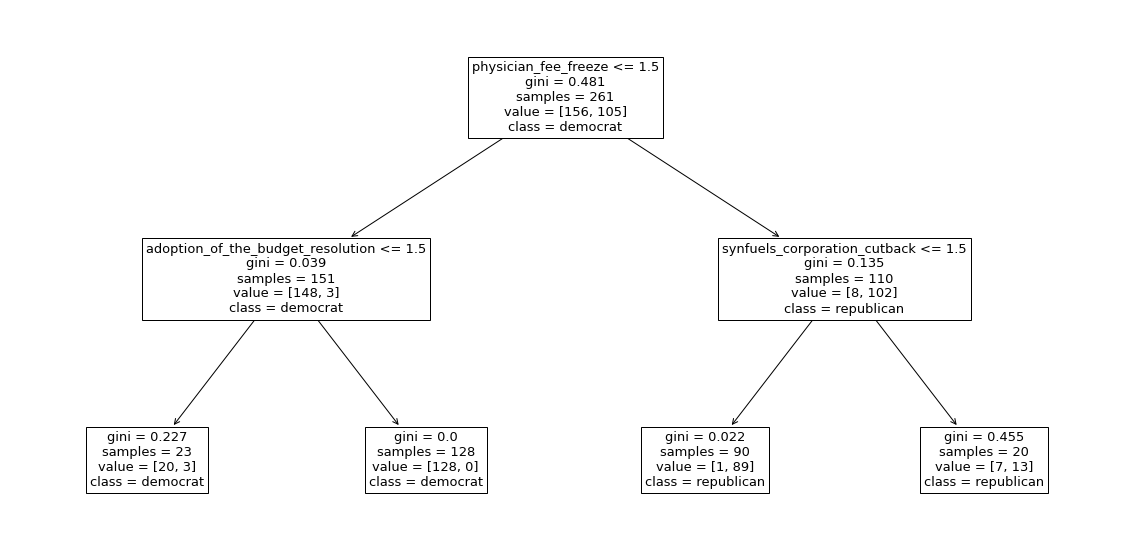

In [ ]:
plot_model(smoler)

Na wizualizacji widać anomalię: po prawej stronie są same liście republikańskie, a po lewej same demokratyczne. Oznacza to, że drzewo decyzyjne pod względem predykcji jest identyczne jak drzewo z tylko jednym podziałem.

In [ ]:
smolest = DecisionTreeClassifier(random_state=420, max_depth=1)
smolest.fit(X=X_train, y=y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=420, splitter='best')

In [ ]:
print_metrics(smolest)

Accuracy score (train): 0.9578544061302682
Accuracy score (test): 0.9540229885057471
Tree depth: 1
Leaf count: 2


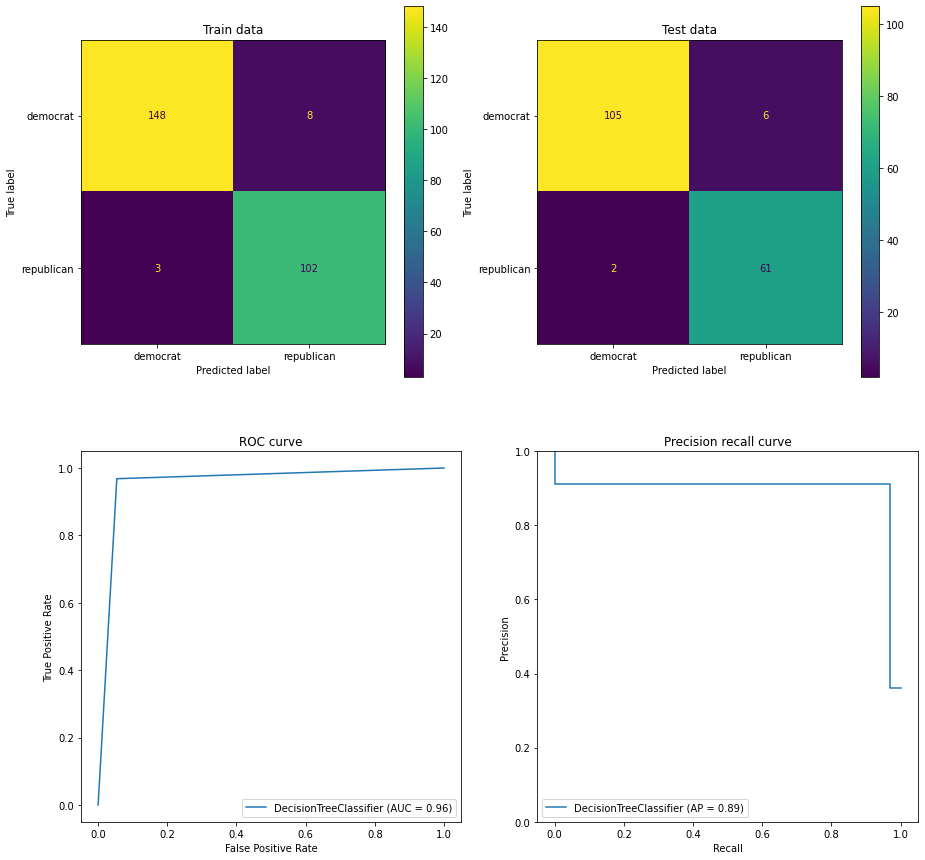

In [ ]:
plot_scores(smolest)

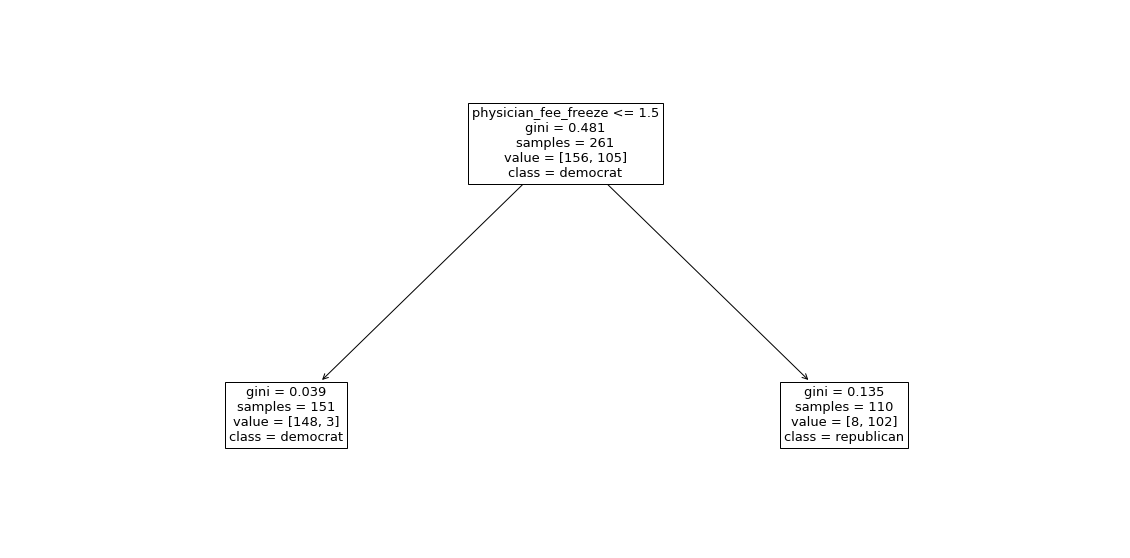

In [ ]:
plot_model(smolest)

Nie oznacza to jednak, że te modele są identyczne - modele różnią się pod względem pewności predykcji. Model z trzema poziomami daje informację kiedy jego decyzja może być mało dokładna, a model z dwoma nie rozróżnia.

In [ ]:
df_proba = pd.DataFrame(smoler.predict_proba(X_test), columns=["Democrat 0 (smoler)", "Republican 1 (smoler)"])
df_proba[["Democrat 0 (smolest)", "Republican 1 (smolest)"]] = smolest.predict_proba(X_test)
df_proba["actual"] = y_test.reset_index(drop=True)
df_proba.drop_duplicates()

,Democrat 0 (smoler),Republican 1 (smoler),Democrat 0 (smolest),Republican 1 (smolest),actual
0,1.000000,0.000000,0.980132,0.019868,0
2,0.011111,0.988889,0.072727,0.927273,1
3,0.011111,0.988889,0.072727,0.927273,0
6,0.869565,0.130435,0.980132,0.019868,0
16,0.350000,0.650000,0.072727,0.927273,1
40,0.869565,0.130435,0.980132,0.019868,1
67,0.350000,0.650000,0.072727,0.927273,0


## Las losowy
A teraz w drugą stronę, zrobimy model black-box i zobaczymy czy jesteśmy w stanie pozbyć się tych kilku niepotrzebnych danych.

Accuracy score (train): 1.0
Accuracy score (test): 0.9482758620689655


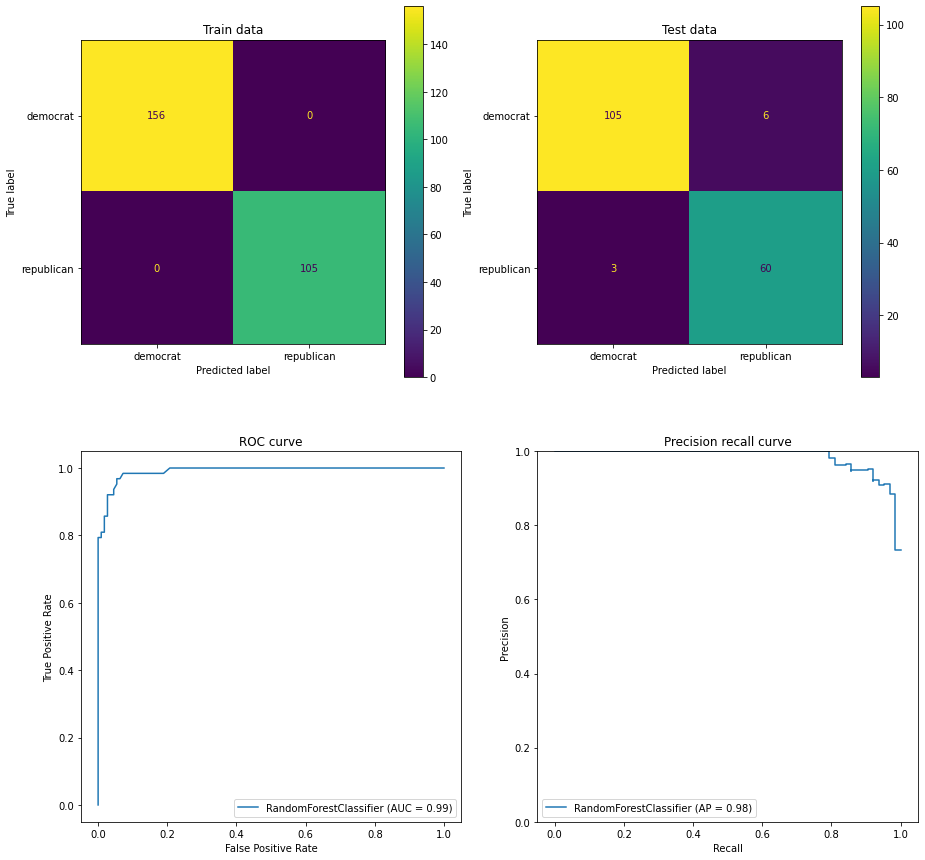

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators= 100,max_depth=8)
forest.fit(X_train,y_train)
plot_scores(forest)

print(f"Accuracy score (train): {forest.score(X_train, y_train)}")
print(f"Accuracy score (test): {forest.score(X_test, y_test)}")

Wręcz idealne accuracy na zbiorze treningowym może budzić niepokój oraz podejrzenie przuczenia, lecz dla drzew o długości 8, model wykazał się wysoką skutecznością na zbiorze testowym.

Accuracy score (train): 0.9425287356321839
Accuracy score (test): 0.9252873563218391


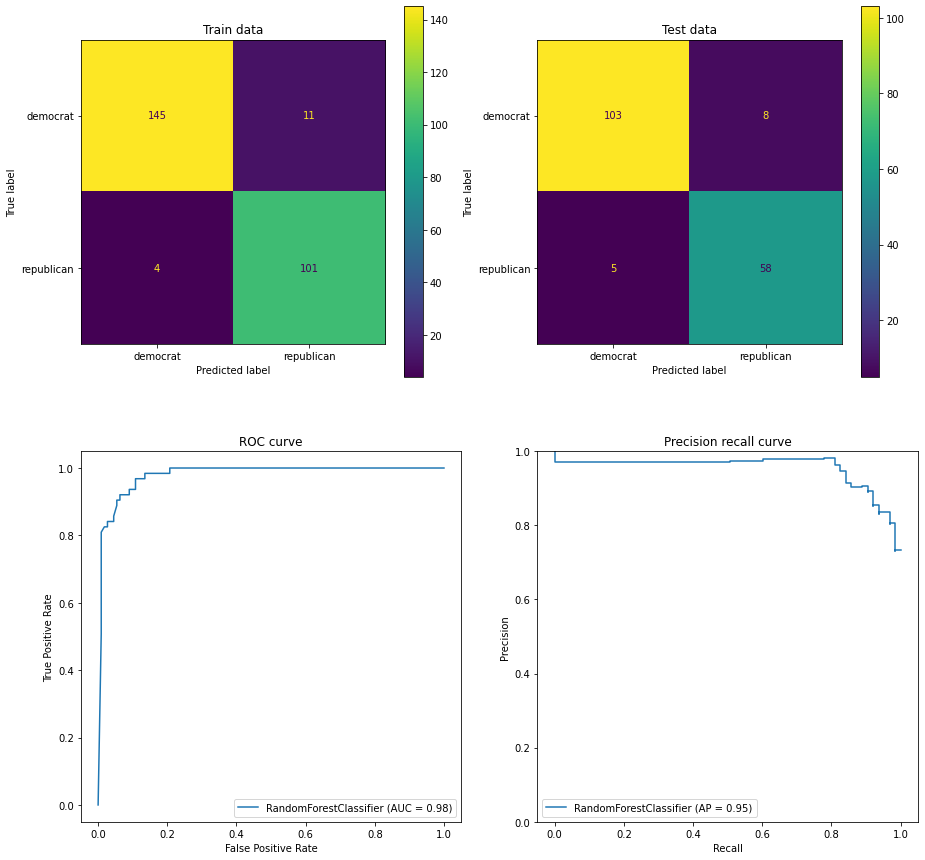

In [ ]:
forest = RandomForestClassifier(n_estimators= 100,max_depth=1)
forest.fit(X_train,y_train)
plot_scores(forest)


print(f"Accuracy score (train): {forest.score(X_train, y_train)}")
print(f"Accuracy score (test): {forest.score(X_test, y_test)}")

Jak widzimy, nawiązując do poprzedniego punktu, zmniejszenie głębokości drzewa nawet do najmniejszego, nadal zwraca satysfakcjonujące wyniki, zatem można dojść do wniosku iż zachodzi podział na republikańskie oraz demokrackie ustawy.

In [ ]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X.drop(["physician_fee_freeze","water_project_cost_sharing","export_administration_act_south_africa"],axis=1), y, random_state=13, test_size=0.4) 
forest = RandomForestClassifier(max_depth=1)
forest.fit(X3_train,y3_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
print(f"Accuracy score (train): {forest.score(X3_train, y3_train)}")
print(f"Accuracy score (test): {forest.score(X3_test, y3_test)}")

Accuracy score (train): 0.9195402298850575
Accuracy score (test): 0.867816091954023


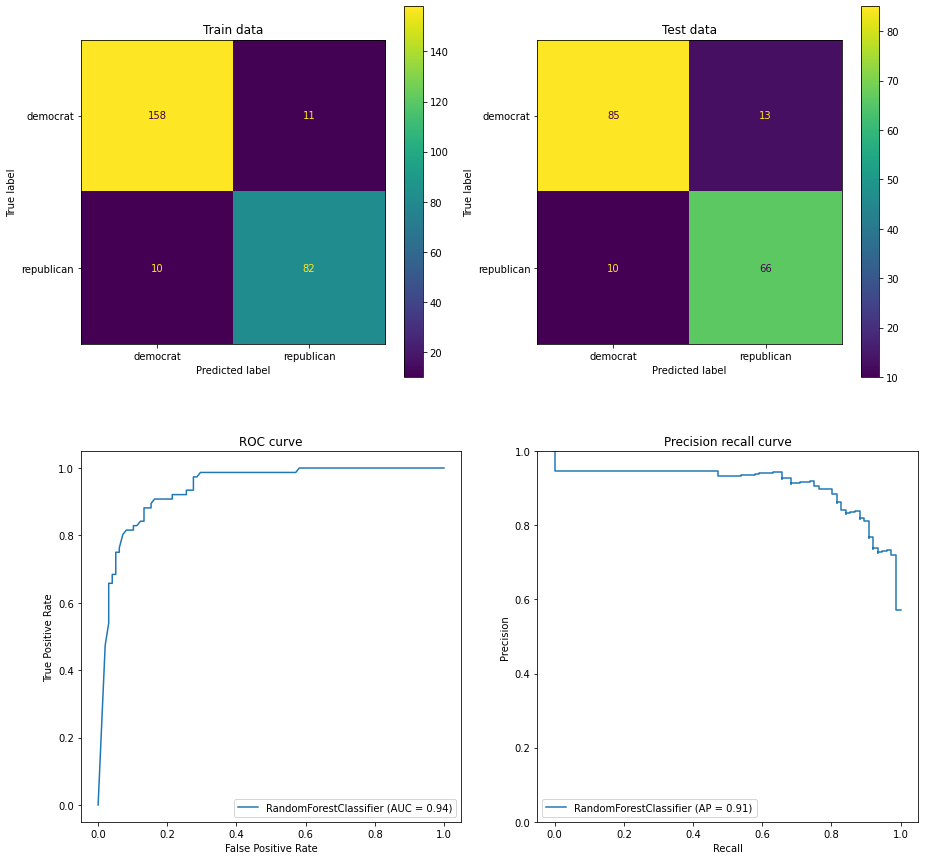

In [ ]:
fig, axs = plt.subplots(2, 2)
plot_confusion_matrix(
    forest, X3_train, y3_train,
    display_labels=party_encoder.classes_,
    values_format="d",
    ax=axs[0, 0]
)
axs[0, 0].set_title("Train data")

plot_confusion_matrix(
    forest, X3_test, y3_test,
    display_labels=party_encoder.classes_,
    values_format="d",
    ax=axs[0, 1]
)
axs[0, 1].set_title("Test data")

plot_roc_curve(forest, X3_test, y3_test, ax=axs[1, 0])
axs[1,0].set_title("ROC curve")

plot_precision_recall_curve(forest, X3_test, y3_test, ax=axs[1, 1])
axs[1, 1].set_title("Precision recall curve")
axs[1, 1].set_ylim(0, 1)

fig.set_size_inches(15, 15)
fig.show()

Jak widzimy zmniejszenie ilości kolumn, wpływa nam na strukturę lasu, mianowicie zmniejsza nam go, co powinno, i jest, związane ze spadkiem accuracy. Tak samo jak pozbycie się kolunm, które wykazały się być najmniej decydujące w klasyfikacji, tutaj wpłyneły na zmniejszenie się accuracy. Niemniej jednak nadal utrzymuje się na poziomie 87%.

## Naiwny Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
print(f"Accuracy score (train): {nb.score(X_train, y_train)}")
print(f"Accuracy score (test): {nb.score(X_test, y_test)}")

Accuracy score (train): 0.9501915708812261
Accuracy score (test): 0.9252873563218391


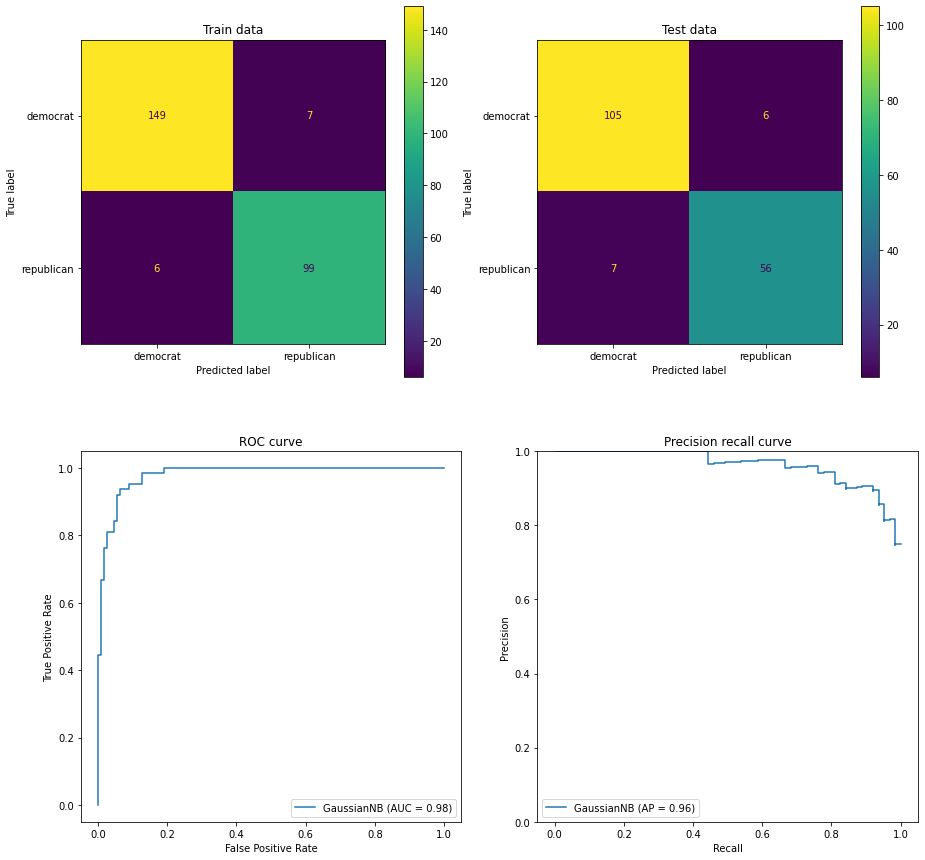

In [ ]:
plot_scores(nb)

Co stanie się gdy nie uwzględnimy "niepotrzebnych" oraz zbyt "silnych" danych?
Przekonajmy się.

In [ ]:
nb2 = GaussianNB()
nb2.fit(X3_train,y3_train)
print(f"Accuracy score (train): {nb2.score(X3_train, y3_train)}")
print(f"Accuracy score (test): {nb2.score(X3_test, y3_test)}")

Accuracy score (train): 0.9003831417624522
Accuracy score (test): 0.8333333333333334


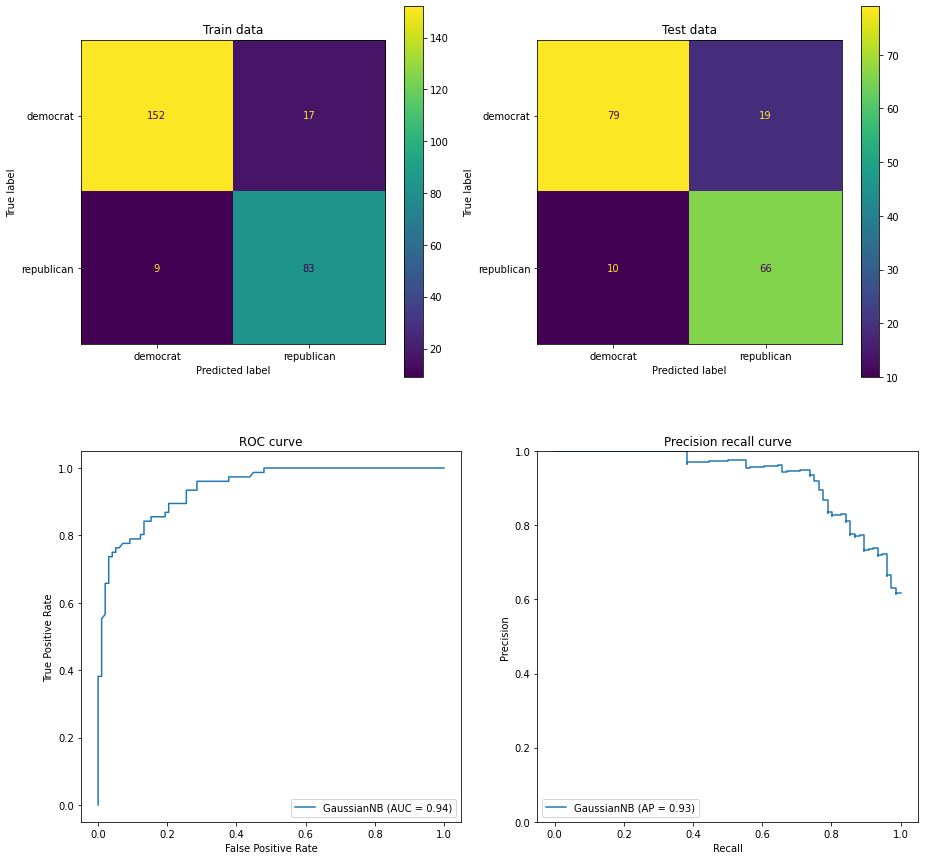

In [ ]:
fig, axs = plt.subplots(2, 2)
plot_confusion_matrix(
    nb2, X3_train, y3_train,
    display_labels=party_encoder.classes_,
    values_format="d",
    ax=axs[0, 0]
)
axs[0, 0].set_title("Train data")

plot_confusion_matrix(
    nb2, X3_test, y3_test,
    display_labels=party_encoder.classes_,
    values_format="d",
    ax=axs[0, 1]
)
axs[0, 1].set_title("Test data")

plot_roc_curve(nb2, X3_test, y3_test, ax=axs[1, 0])
axs[1,0].set_title("ROC curve")

plot_precision_recall_curve(nb2, X3_test, y3_test, ax=axs[1, 1])
axs[1, 1].set_title("Precision recall curve")
axs[1, 1].set_ylim(0, 1)

fig.set_size_inches(15, 15)
fig.show()

## Bez ekstremalnej ustawy

Jak sprawdzi się model bez kolumny "physician_fee_freeze", która wręcz samodzielnie dokonała dość precyzyjnej (pod względem accuracy) klasyfikacji. Czy nasz dzielny model poradzi sobie pomimo braku takiego twardziela? Przekonajmy się !!!

In [ ]:
X2 = X.drop("physician_fee_freeze", axis=1)

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, random_state=11, test_size=0.4)

In [ ]:
t4 = DecisionTreeClassifier(max_depth=3, random_state=33)

t4.fit(X2_train, y2_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=33, splitter='best')

In [ ]:
print(f"Accuracy score (train): {t4.score(X2_train, y2_train)}")
print(f"Accuracy score (test): {t4.score(X2_test, y2_test)}")
print(f"Tree depth: {t4.get_depth()}")
print(f"Leaf count: {t4.get_n_leaves()}")

Accuracy score (train): 0.9080459770114943
Accuracy score (test): 0.8735632183908046
Tree depth: 3
Leaf count: 7


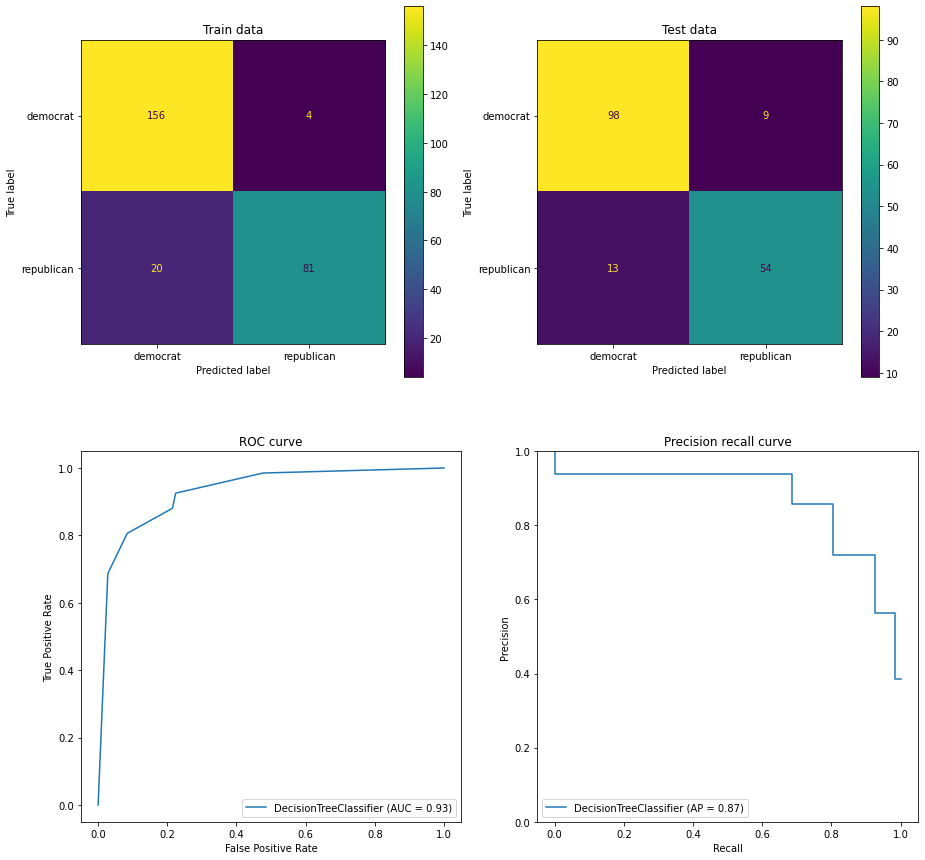

In [ ]:
fig, axs = plt.subplots(2, 2)
plot_confusion_matrix(
    t4, X2_train, y2_train,
    display_labels=party_encoder.classes_,
    values_format="d",
    ax=axs[0, 0]
)
axs[0, 0].set_title("Train data")

plot_confusion_matrix(
    t4, X2_test, y2_test,
    display_labels=party_encoder.classes_,
    values_format="d",
    ax=axs[0, 1]
)
axs[0, 1].set_title("Test data")

plot_roc_curve(t4, X2_test, y2_test, ax=axs[1, 0])
axs[1,0].set_title("ROC curve")

plot_precision_recall_curve(t4, X2_test, y2_test, ax=axs[1, 1])
axs[1, 1].set_title("Precision recall curve")
axs[1, 1].set_ylim(0, 1)

fig.set_size_inches(15, 15)
fig.show()

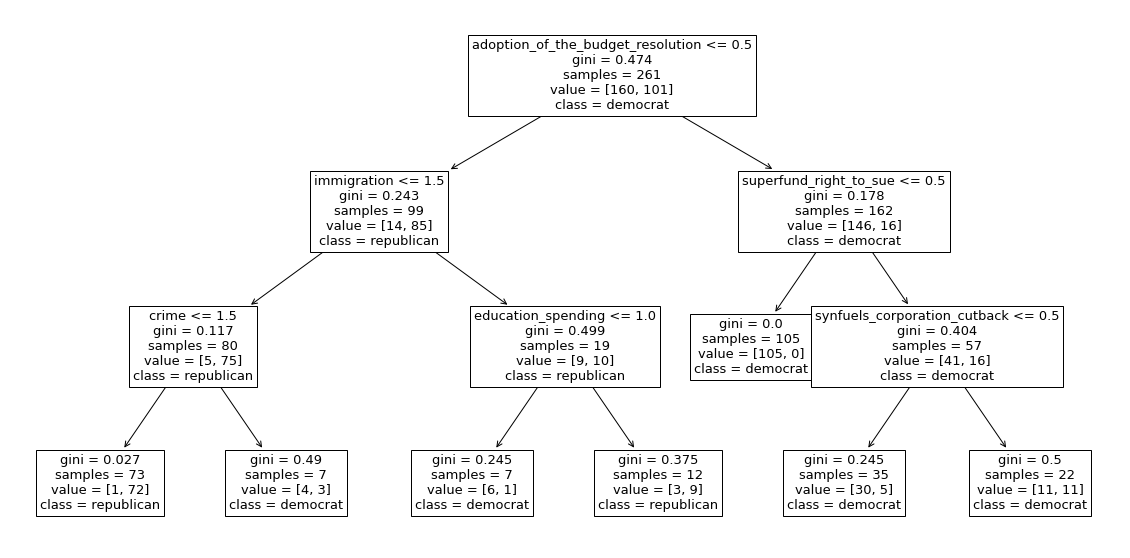

In [ ]:
plot_model(t4)

# Podsumowanie, zakończenie
Jak widzimy, zaskakująco wszystkie nasze modele poradziły sobie z średnio 90% procentową skutecznością jeżeli chodzi o klasyfikacje danych, i na tym moglibyśmy zakończyć naszą pracę okrzyknąwszy ją sukcesem, lecz jako inżynierzy danych, my szukamy czegoś więcej, my szukamy głębszej prawdy.

Przez specyficzność naszej ramki danych, modele okazywały się nie mieć większych problemów. Problematyczne okazały się w szczególności pewne klasyfikatory, które wręcz na własną rękę dokonywały poprawengo przydziału! Ostatecznie zmodyfikowaliśmy ramkę, by była jak najbardziej "fair" dla postawionego dla nas zadania.

Jaka płynie z tego lekcja? Politycy, szczególnie przy binarnym podziale partyjnym, są przewidywalni, oraz już w latach 80 między politykami panowała polaryzacja polityczna.